In [1]:

# Copyright 2021 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

### Debiasing Facial Detection Systems


##### We will build facial detection model that learns the latent viariables underlying face image datasets and uses thus to adaptively re-sample the training data, thus mitigating any biases that may be present in order to train a debiased model.

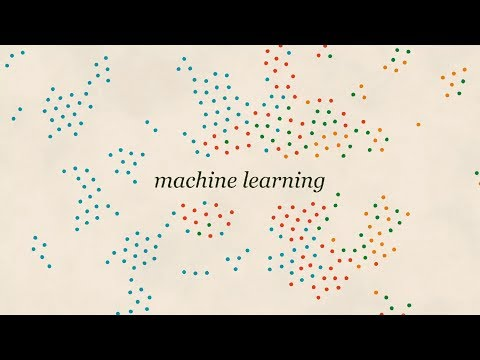

In [2]:
import IPython
IPython.display.YouTubeVideo('59bMh59JQDo')

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print('gpu', gpu)
    tf.config.experimental.set_memory_growth(gpu, True)
    print('memory growth:' , tf.config.experimental.get_memory_growth(gpu))
    

gpu PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
memory growth: True


In [4]:
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import mitdeeplearning as mdl

### Datasets

#### We'll be using three datasets.

1. Positive training data: CelebA Dataset. A large-scale (over 200K images) of celebrity faces.
2. Negative training data: ImageNet. Many images across many different categories. We'll take negative examples from a variety of non-human categories. Fitzpatrick Scale skin type classification system, with each image labeled as "Lighter'' or "Darker''.

In [7]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263894528/1263889489 [==============================] - 224s 0us/step
Opening /home/dawidkubicki/.keras/datasets/train_face.h5
Loading data into memory...


In [9]:
#let's look at a size of training example of batch size 100
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

print(number_of_training_examples)

109914


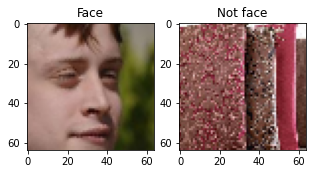

In [16]:
#play around with displaying images to get a sense of what the training data actually looks like!

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 23
idx_not_face = 6

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1,2,2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not face"); plt.grid(False)

### Define and train the CNN based model (without debiased model)

In [18]:
n_filters = 12

def make_standard_classifier(n_outputs=1):
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    
    model = tf.keras.Sequential([
        Conv2D(filters=1*n_filters, kernel_size=5, strides=2),
        BatchNormalization(),
        
        Conv2D(filters=2*n_filters, kernel_size=5, strides=2),
        BatchNormalization(),
        
        Conv2D(filters=4*n_filters, kernel_size=3, strides=2),
        BatchNormalization(),

        Conv2D(filters=6*n_filters, kernel_size=3, strides=2),
        BatchNormalization(),
        
        Flatten(),
        Dense(512),
        Dense(n_outputs, activation=None),
    ])
    return model

standard_classifier = make_standard_classifier()

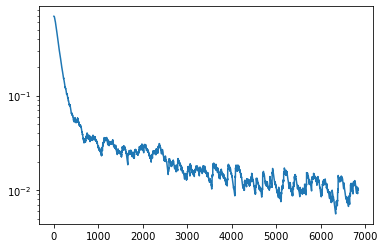

100%|██████████| 3434/3434 [00:16<00:00, 209.03it/s]


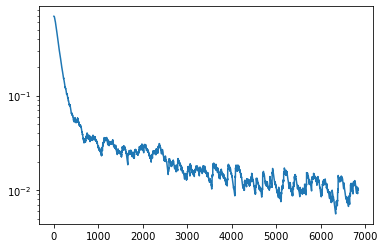

In [19]:
#let's train it

#training hyperparameters
batch_size = 32
num_epochs = 2
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
    with tf.GradientTape() as tape:
        #feed the images into the model
        logits = standard_classifier(x)
        #compute the loss
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
        
    #backpropagation
    grads = tape.gradient(loss, standard_classifier.trainable_variables)
    optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
    return loss

# The training loop!
for epoch in range(num_epochs):
    for idx in tqdm(range(loader.get_train_size()//batch_size)):
        # Grab a batch of training data and propagate through the network
        x, y = loader.get_batch(batch_size)
        loss = standard_train_step(x, y)

        # Record the loss and plot the evolution of the loss as a function of training
        loss_history.append(loss.numpy().mean())
        plotter.plot(loss_history.get())

### Evaluate performance of the standard CNN

In [20]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) training set: 0.9932


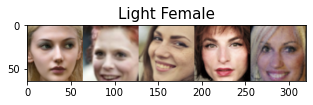

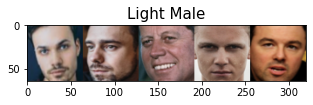

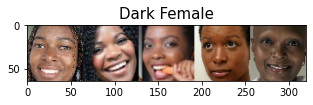

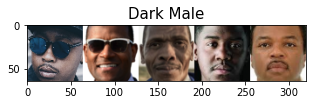

In [21]:

### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys): 
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

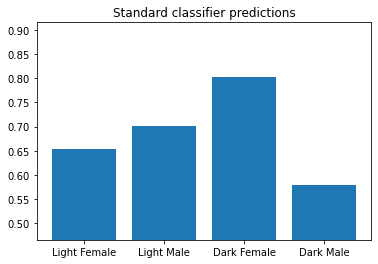

In [22]:

### Evaluate the standard CNN on the test data ### 

standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions");